In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import torch
from transformers import BertTokenizer, BertModel
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score
from transformers import DataCollatorWithPadding
import evaluate
import wandb
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict


### Useful link
https://huggingface.co/docs/transformers/en/tasks/sequence_classification

### Sample dataset creation

In [30]:
# Create a sample dataset with 50 rows
data = {
    'Label': ['AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC',
              'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC',
              'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC',
              'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC',
              'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC', 'AD', 'HC'],  
    'Text': [
        "I sometimes forget where I placed my keys, and it frustrates me.",
        "I feel good today, everything seems normal.",
        "I don’t remember the name of the person I met last week.",
        "I just had a productive day at work, feeling great!",
        "I have trouble remembering faces of people I know.",
        "I’m planning a trip this weekend, very excited!",
        "I need help recalling a word, it’s right on the tip of my tongue.",
        "I’m feeling a bit tired today but nothing serious.",
        "I keep forgetting the names of my close friends.",
        "I just finished reading a great book last night.",
        "I’m having trouble remembering things I used to know easily.",
        "I’ve been feeling a bit under the weather, but nothing major.",
        "I don’t remember what I had for lunch yesterday.",
        "I’ve been exercising regularly, and it feels amazing.",
        "I’m always forgetting where I leave things around the house.",
        "My memory has been a bit off lately, but I manage.",
        "I often repeat myself in conversations with my family.",
        "I love to take long walks in the park during the weekend.",
        "I sometimes forget appointments and meetings, which worries me.",
        "I’m spending more time reading lately, feels great to keep my mind active.",
        "I’ve been trying out new hobbies, it’s been refreshing.",
        "I noticed I mix up words more frequently now.",
        "I feel great and am looking forward to my upcoming vacation.",
        "I get frustrated sometimes because I can’t remember people’s names.",
        "I went shopping today and bought some new clothes.",
        "I’ve been having trouble recalling recent events.",
        "I don’t remember what I did earlier today, it's strange.",
        "I’m learning a new language, and it’s exciting.",
        "I’m not sure where I left my phone, this is becoming a habit.",
        "I find it hard to keep track of multiple things at once.",
        "I’m eating healthier now, trying to stay fit.",
        "I have trouble recalling specific words when talking.",
        "I’ve been doing well overall, just tired from work.",
        "I keep forgetting people’s birthdays, it’s embarrassing.",
        "I’m feeling very energetic and optimistic today.",
        "I have been more forgetful recently, but I’m coping.",
        "I can't seem to remember the names of new acquaintances.",
        "I’m planning a dinner party for next weekend, very excited.",
        "I’ve noticed a decline in my memory, which makes me anxious.",
        "I enjoy cooking and trying new recipes.",
        "I’m trying to stay positive despite some memory lapses.",
        "I often forget the details of conversations I’ve had.",
        "I’m feeling a bit overwhelmed by all the things I need to do.",
        "I keep losing track of time during the day.",
        "I can remember things from a long time ago but forget recent events.",
        "I’ve been having trouble concentrating on tasks at work.",
        "I’m looking forward to meeting old friends this weekend.",
        "I keep misplacing my glasses, it’s getting annoying.",
        "I have noticed my short-term memory isn't as sharp as it used to be.", 
    "I sometimes forget what I was talking about mid-conversation."
    ]  # Ensure 50 texts
}


df = pd.DataFrame(data)

df.head(2)


,Label,Text
0,AD,"I sometimes forget where I placed my keys, and..."
1,HC,"I feel good today, everything seems normal."


## Fisrt Way: Explicitly Embedding Extraction

## 'intfloat/multilingual-e5-large' model
https://huggingface.co/intfloat/multilingual-e5-large

In [31]:
model_name = 'intfloat/multilingual-e5-large'
model = SentenceTransformer(model_name)

In [32]:
# Check if GPU is available and move the model to GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [33]:
def extract_embeddings(df, text_column, label_column, model):
    texts = ["passage: " + text for text in df[text_column].tolist()]  # Add "passage:" or "query: "  prefix
    labels = df[label_column].tolist()
    embeddings = model.encode(texts, normalize_embeddings=True)
    return np.vstack(embeddings), np.array(labels)


In [34]:
X_train, y_train = extract_embeddings(df, 'Text', 'Label', model)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

## Binary classification using SVM and the extracted embedding

In [35]:
# Create the SVM model
svm_model = make_pipeline(SVC(kernel='rbf', C=1, gamma='scale', random_state=42))

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test set (you can use X_test for this)
y_pred = svm_model.predict(X_train)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_train, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))



Classification Report:
              precision    recall  f1-score   support

          AD       0.86      0.76      0.81        25
          HC       0.79      0.88      0.83        25

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.82      0.82      0.82        50

Confusion Matrix:
[[19  6]
 [ 3 22]]


### Confusion matrix visulization

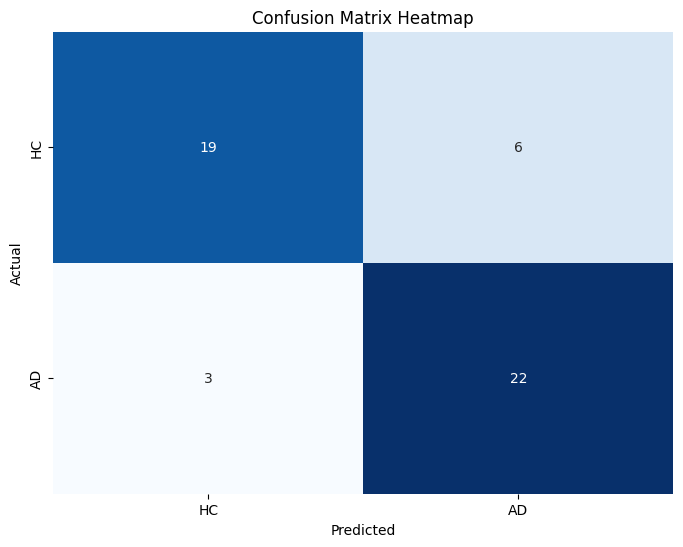

In [36]:
# Generate the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Create a heatmap for the confusion matrix without the color bar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['HC', 'AD'], yticklabels=['HC', 'AD'], cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## M-BERT embedding extraction
https://huggingface.co/google-bert/bert-base-multilingual-cased

In [37]:
# Load mBERT tokenizer and model
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set model to evaluation mode (no gradients needed)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

## Why Use Only the [CLS] Token?  
In BERT-based models, **the [CLS] token** (first token, outputs.last_hidden_state[:, 0, :]) is **often used as a summary representation of the entire sequence**.  
This is because pre-training tasks in BERT (like next-sentence prediction) train the model **to encode meaningful information into this token**.  
This makes it useful for classification tasks, where the full sequence representation is not needed.

In [38]:
# Function to extract embeddings from mBERT
def extract_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Extract CLS token embedding
    return cls_embedding


In [39]:
# Apply embedding extraction to all texts
df['embedding'] = df['Text'].apply(extract_embedding)

# Convert list of embeddings into a NumPy array
X = np.vstack(df['embedding'].values)  # Features
y = df['Label'].values  # Labels

Accuracy: 0.7000
Classification Report:
               precision    recall  f1-score   support

          AD       0.75      0.60      0.67         5
          HC       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



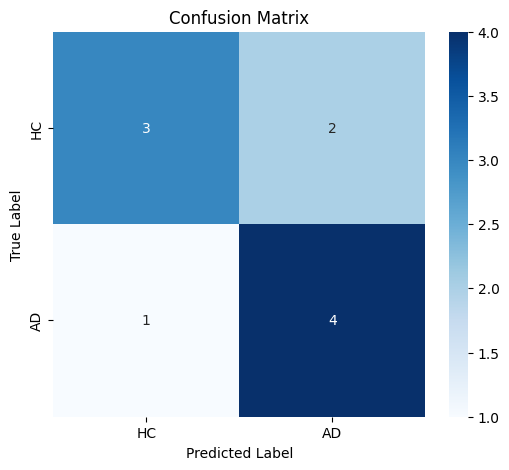

In [40]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix with Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["HC", "AD"], yticklabels=["HC", "AD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Second way: Extracting embedding implicitly and fine tunning

## Embedding Extraction (Implicitly through fine tunning  m-BERT)

The code tokenizes text using a tokenizer and feeds it into a BERT-based model (bert-base-multilingual-cased), which **generates contextual embeddings** .   
These embeddings are not explicitly extracted in the code, but they are internally computed within the model.  

**Binary Classification**  
The task is to classify between Alzheimer's Disease (AD) and Healthy Control (HC).  
Labels (AD: 1, HC: 0) are mapped and assigned to the dataset.  
A pre-trained BERT model (AutoModelForSequenceClassification) is fine-tuned on this dataset for binary classification.  

In [41]:
!pip install evaluate

In [42]:
def preprocess_function(examples):
    encoding = tokenizer(examples["Text"], truncation=True)
    encoding["labels"] = examples["labels"]  
    return encoding


# Label mapping

diagnosis_mapping = {'AD': 1, 'HC':0}
df['Label'] = df['Label'].replace(diagnosis_mapping)

<ipython-input-42-ed412cdbb075>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace(diagnosis_mapping)


In [43]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

# Reset the index to avoid the inclusion of the index column
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

In [44]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [45]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [46]:

id2label = {0: "HC", 1: "AD"}
label2id = {"HC": 0, "AD": 1}


In [47]:

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=2, id2label=id2label, label2id=label2id
)


# Check if a GPU is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

# Move the model to GPU
model.to(device)

wandb.login(key="your_key")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [48]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # You can try increasing this for faster training
    per_device_eval_batch_size=16,  # Same for evaluation batch size
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
    fp16=True,  
    logging_strategy="epoch" 
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-48-f46df01c700b>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700300,0.706689,0.500000
2,0.685200,0.704736,0.500000
3,0.639200,0.687451,0.500000
4,0.660000,0.683154,0.400000
5,0.641800,0.671289,0.800000


TrainOutput(global_step=15, training_loss=0.6652872721354167, metrics={'train_runtime': 54.9396, 'train_samples_per_second': 3.64, 'train_steps_per_second': 0.273, 'total_flos': 2104888442880.0, 'train_loss': 0.6652872721354167, 'epoch': 5.0})

## Fine tunning when the base model is unfreezed

In [49]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", num_labels=2, id2label=id2label, label2id=label2id
)

# Unfreeze the entire base model (BERT backbone)
for param in model.bert.parameters():
    param.requires_grad = True  # Unfreezing BERT layers for fine-tuning


# Check if a GPU is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

# Move the model to GPU
model.to(device)

wandb.login(key="1dab45bb7a6363a8101229ef0e9d95235550966e")


training_args = TrainingArguments(
    output_dir="/kaggle/working/my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # You can try increasing this for faster training
    per_device_eval_batch_size=16,  # Same for evaluation batch size
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
    fp16=True,  
    logging_strategy="epoch" 
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-49-f06b8f7cc901>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.700300,0.706689,0.500000
2,0.685200,0.704736,0.500000
3,0.639200,0.687451,0.500000
4,0.660000,0.683154,0.400000
5,0.641800,0.671289,0.800000


TrainOutput(global_step=15, training_loss=0.6652872721354167, metrics={'train_runtime': 44.5069, 'train_samples_per_second': 4.494, 'train_steps_per_second': 0.337, 'total_flos': 2104888442880.0, 'train_loss': 0.6652872721354167, 'epoch': 5.0})

## Unfreeze only the last 2 encoder layers

In [ ]:
# Freeze all layers first
for param in model.bert.parameters():
    param.requires_grad = False  

# Unfreeze only the last 2 encoder layers
for layer in model.bert.encoder.layer[-2:]:  # Adjust the number of layers to unfreeze
    for param in layer.parameters():
        param.requires_grad = True